In [1]:
import copy
import sys
from collections.abc import Iterable
from functools import reduce

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

print("python version: ", sys.version_info)
print(np.__name__, np.__version__)

python version:  sys.version_info(major=3, minor=7, micro=2, releaselevel='final', serial=0)
numpy 1.17.0


## 1. Numpy实现Linear Regressor

$w=\left(X^{\top} X\right)^{-1} X^{\top} Y$  

### 1.1 NumpyBaseEstimator

In [2]:
class NumpyBaseEstimator:
    """Numpy estimator base class for all numpy estimator."""

    def _fit_validation(self, X, y):
        """valid fit method's params

        Args:
            X: feature data for training. A np.ndarray matrix of (n_samples,
                n_features) shape, data type must be continuous value type.
            y: label data for training. A np.ndarray array of (n_samples, ) shape.

        Returns:
            np.ndarray type data of X and y.

        Raises:
            AssertionError: Error type of X or y, or mismatched shape for X or y.
        """
        assert isinstance(X, Iterable) and isinstance(y, Iterable)
        assert len(X) == len(y)
        X = X if isinstance(X, np.ndarray) else np.array(X)
        y = y if isinstance(y, np.ndarray) else np.array(y)
        if X.ndim != 2:
            raise ValueError(f"X dim must be 2, got {X.ndim} dim of X! ")
        return X, y

    def _predict_validation(self, X_test):
        """valid predict method's params

        Args:
            X_test: feature data for predicting. A np.ndarray matrix of (n_samples,
                n_features) shape, data type must be continuous value type.

        Returns:
            np.ndarray type data of X_test.

        Raises:
            AssertionError: Error type of X_test.
            ValueError: Mismatched shape for X_test.
        """
        assert isinstance(X_test, Iterable)
        X_test = X_test if isinstance(X_test, np.ndarray) else np.array(X_test)
        error_text = f"Mismatched shape for X_test! Get {X_test.shape}, only" \
                     f" ({self._X_train.shape[1]}, ) or (_, {self._X_train.shape[1]}) " \
                     f"X_test can be."
        if X_test.ndim == 1:
            if X_test.shape[0] != self._X_train.shape[1]:
                raise ValueError(error_text)
        elif X_test.ndim == 2:
            if X_test.shape[1] != self._X_train.shape[1]:
                raise ValueError(error_text)
        else:
            raise ValueError(f"X_test with the {X_test.ndim} dim! Only 1 or 2 dim X_test can be.")
        return X_test

    def _score_validation(self, X_test, y_test):
        """valid score method's params

        Args:
            X_test: feature data for training. A np.ndarray matrix of (n_samples,
                n_features) shape, data type must be continuous value type.
            y_test: label data for training. A np.ndarray array of (n_samples, ) shape.

        Returns:
            np.ndarray type data of X_test and y_test.

        Raises:
            AssertionError: Error type of X_test or y_test.
            ValueError: Mismatched shape for X_test or y_test.
        """
        X_test = self._predict_validation(X_test)
        is_valid = True
        if isinstance(y_test, Iterable):
            if X_test.shape[0] != len(y_test):
                is_valid = False
            elif X_test.ndim == 1:
                is_valid = False
        else:
            assert isinstance(y_test, int) or isinstance(y_test, float)
            if X_test.ndim != 1:
                is_valid = False
        y_test = np.array(y_test)
        if not is_valid:
            raise ValueError(f"Mismatched shape for y_test! X_test with {X_test.shape} shape, but "
                             f"y_test's shape is {y_test.shape}")
        return X_test, y_test

### 1.2 NumpyRegressorMixin

In [3]:
class NumpyRegressorMixin:
    """Regressor Mixin with numpy. Mainly realized the score method."""

    def score(self, X_test, y_test):
        """Use test dataset to evaluate the trained model.

        Args:
            X_test: A np.ndarray matrix of (n_samples, n_features) shape.
            y_test: A np.ndarray array of (n_samples, ) shape. data type must be
                discrete value.
        Returns:
            return R^2, R^2 = 1 - u / v. u = sum((y_pred - y_true)^2), v = sum((y_true - y_true_mean)^2)
        """
        X_test, y_test = self._score_validation(X_test, y_test)
        y_pred = self.predict(X_test, _miss_valid=True)
        y_true_mean = np.mean(y_test, axis=0)
        u = np.sum(np.square(y_pred - y_test))
        v = np.sum(np.square(y_test - y_true_mean))
        r_squared = 1 - u / v
        return r_squared

### 1.3 NumpyBaseLinearRegressor

In [4]:
class NumpyBaseLinearRegressor(NumpyBaseEstimator, NumpyRegressorMixin):
    """Linear regressor base class with numpy, explicitly inherits from NumpyBaseEstimator
        and NumpyRegressorMixin already.
    
    Attributes:
        _X_train:feature data for training. A np.ndarray matrix of (n_samples, 
            n_features) shape, data type must be continuous value type. 
        _y_train:label data for training. A np.ndarray array of (n_samples, ) shape, 
            data type must be continuous value.
        coef_: coef of linear regressor. A np.ndarray array of (n_features, ) shape.
        intercept_: intercept of regressor. A np.ndarray integer.
    """

    def __init__(self, fit_intercept=True, random_state=None):
        """linear regressor init method.
        
        Args:
            fit_intercept: Bool value. If use intercept in the linear regressor model.
        """
        fit_intercept, random_state = self._init_validation(fit_intercept, random_state)
        self._X_train = None
        self._y_train = None
        self.coef_ = None
        if random_state is not None:
            np.random.seed(random_state)
        self.intercept_ = np.random.randn() if fit_intercept else None

    def fit(self, X_train, y_train):
        """method for training model. 
        
        Args:
            X_train: A np.ndarray matrix of (n_samples, n_features) shape, 
                data type must be continuous value type. 
            y_train: A np.ndarray array of (n_samples, ) shape.
        
        Returns:
            self object.
        """
        self._X_train, self._y_train = self._fit_validation(X_train, y_train)
        if self.intercept_ is not None:
            self._X_train = np.c_[self._X_train, np.ones((self._X_train.shape[0], 1))]
        self._calculate_coef()
        if self.intercept_ is not None:
            self.intercept_ = self.coef_[-1]
            self.coef_ = np.delete(self.coef_, -1)
            self._X_train = np.delete(self._X_train, -1, axis=1)
        return self

    def predict(self, X_test, _miss_valid=False):
        """predict test data.
        
        Args:
            X_test: A np.ndarray matrix of (n_samples, n_features) shape, 
                or a np.ndarray array of (n_features, ) shape.
        """
        if not _miss_valid:
            X_test = self._predict_validation(X_test)
        product = X_test @ self.coef_
        return product if self.intercept_ is None else product + self.intercept_
    
    def _init_validation(self, fit_intercept, random_state):
        assert isinstance(fit_intercept, bool)
        assert isinstance(random_state, (int, type(None)))
        return fit_intercept, random_state

### 1.4 NumpyLinearRegressor

In [5]:
class NumpyLinearRegressor(NumpyBaseLinearRegressor):
    """Linear regressor class with numpy, explicitly inherits from NumpyBaseLinearRegressor already.
    
    Attributes:
        _X_train:feature data for training. A np.ndarray matrix of (n_samples, n_features) shape, 
            data type must be continuous value type. 
        _y_train:label data for training. A np.ndarray array of (n_samples, ) shape, 
            data type must be continuous value.
        coef_: coef of linear regressor. A np.ndarray array of (n_features, ) shape.
        intercept_: intercept of regressor. A np.ndarray integer.
    """

    def _calculate_coef(self):
        xtx = self._X_train.T @ self._X_train
        try:
            xtx_inv = np.linalg.inv(xtx)
        except np.linalg.LinAlgError as ex:
            raise ex
        self.coef_ = xtx_inv @ self._X_train.T @ self._y_train

### 1.5 生成数据

In [6]:
def load_linear_data(point_count=100, min_=0., max_=10., w=0.5493, b=1.1973, random_state=None, scale=1.0, loc=0.0):
    """load linear data

    Args:
        point_count: a integer number, default = 100.
        min_: bottom range of x data, a float number, default = 0.0.
        max_: top range of x data, a float number, default = 10.0.
        w: the coef of linear, a float number, default = 0.5493.
        b: the intercept of linear, a float number, default = 1.1973.
        random_state: random seed, a int number, default = None.
        scale: noise's scale. A float number, default = 1.0.
        loc: noise's loc. A float number, default = 0.0

    Returns:
        A tuple. (x, y). the shape of x is (point_count, 1), the shape
            of y is (point_count, ).

    Raises:
        AssertionError: random_state is not a integer.
    """
    if random_state is not None:
        assert isinstance(random_state, int)
        np.random.seed(random_state)

    x = np.random.uniform(min_, max_, point_count)
    noise = np.random.normal(scale=scale, loc=loc, size=[point_count])
    y = w * x + b + noise
    return x.reshape([-1, 1]), y

In [7]:
x, y = load_linear_data(1000)

In [8]:
x.shape

(1000, 1)

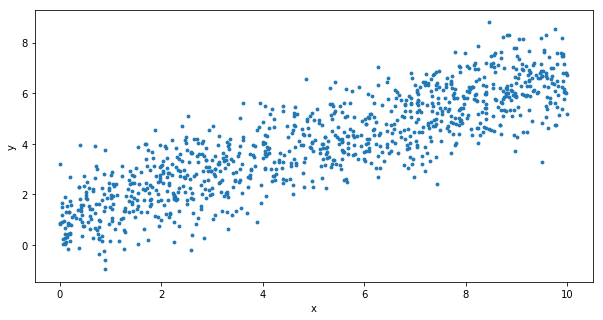

In [9]:
plt.figure(figsize=[10, 5])
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x, y, s=8)
plt.show()

In [10]:
rgs = NumpyLinearRegressor(fit_intercept=True)
rgs.fit(x, y)
rgs.coef_, rgs.intercept_

(array([0.56199546]), 1.1418439527206572)

### 1.6 绘制回归拟合直线

In [11]:
def show_regressor_linear(X_data, y_data, pred_coef, pred_intercept=0):
    """show the regression linear and data point.
    
    Args:
        X_data: A np.ndarray matrix of (point_count, 1) shape, 
            data type must be continuous value type. 
        y_data: A np.ndarray array of (point_count, ) shape.
        pred_coef: prediction coef. A np.ndarray matrix of (1, ) shape.
        pred_intercept: prediction coef. A np.ndarray integer or interge, default = 0.
    """
    if pred_intercept is None:
        pred_intercept = 0
    plt.figure(figsize=[10, 5])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(X_data, y_data, label="true", s=12)
    pred_y = pred_coef * X_data + pred_intercept
    plt.plot(X_data, pred_y, label="pred", color="darkorange")
    plt.legend()
    plt.show()

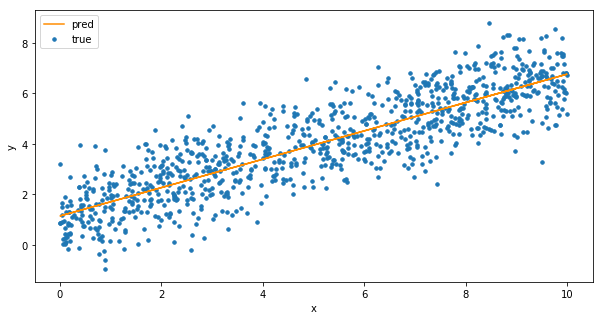

In [12]:
show_regressor_linear(
    X_data=x, y_data=y, pred_coef=rgs.coef_, pred_intercept=rgs.intercept_
)

## 2. Numpy实现Ridge

$\hat{w}=\arg \min _{w} J(w)=\left(X^{\top} x+\lambda I\right)^{-1} x^{\top} Y$

In [13]:
class NumpyRidge(NumpyBaseLinearRegressor):
    """Ridge class with numpy. explicitly inherits from NumpyBaseLinearRegressor already.
    
    Attributes:
        _X_train:feature data for training. A np.ndarray matrix of (n_samples, n_features) shape, 
            data type must be continuous value type. 
        _y_train:label data for training. A np.ndarray array of (n_samples, ) shape, 
            data type must be continuous value.
        coef_: coef of linear regressor. A np.ndarray array of (n_features, ) shape.
        intercept_: intercept of regressor. A np.ndarray integer.
        alpha: the regularize rate. A positive float number, default = 1.0.
    """

    def __init__(self, fit_intercept=True, alpha=1.0, random_state=None):
        """ridge object init method.
        
        Args:
            fit_intercept: Bool value. If use intercept in the ridge model.
            alpha: the regularize rate. A positive float number, default = 1.0.
        
        Raises:
            AssertionError: Alpha value must be a number.
            ValueError: Alpha value must be greater than 0.
        """
        super().__init__(fit_intercept=fit_intercept, random_state=random_state)
        assert isinstance(alpha, int) or isinstance(alpha, float)
        if 0 < alpha:
            self.alpha = alpha
        else:
            raise ValueError("Alpha value must be greater than 0! ")

    def _calculate_coef(self):
        xtx = self._X_train.T @ self._X_train
        self.coef_ = (
            np.linalg.inv(xtx + self.alpha * np.identity(self._X_train.shape[1])) \
            @ self._X_train.T \
            @ self._y_train
        )

In [14]:
rgs = NumpyRidge(fit_intercept=True, alpha=0.5, random_state=12)
rgs.fit(x, y)
rgs.coef_, rgs.intercept_

(array([0.5622924]), 1.1397567567796922)

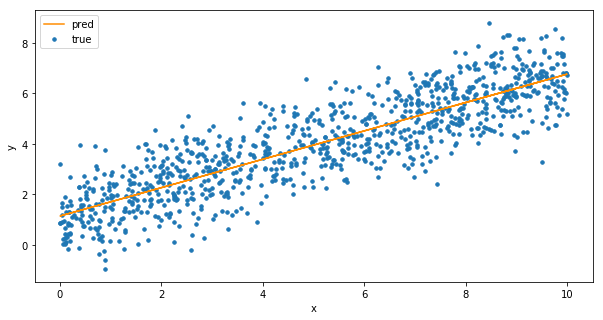

In [15]:
show_regressor_linear(
    X_data=x, y_data=y, pred_coef=rgs.coef_, pred_intercept=rgs.intercept_
)

## 3. Numpy实现SGD Regressor

$\frac{\partial \mathcal{L}}{\partial w}= \frac{2}{n} \sum_{i=1}^{n}\left(w x^{(i)}+b-y^{(i)}\right) \cdot x^{(i)}$

$\frac{\partial \mathcal{L}}{\partial b} =\frac{2}{n} \sum_{i=1}^{n}\left(w x^{(i)}+b-y^{(i)}\right)$

### 3.1 NumpySGDBaseEstimator

In [16]:
class NumpySGDBaseEstimator:
    """SGD Estimator Base class with numpy.
    
    Attributes:
        _X_train:feature data for training. A np.ndarray matrix of (n_samples,
            n_features) shape, data type must be continuous value type. 
        _y_train:label data for training. A np.ndarray array of (n_samples, ) shape, 
            data type must be continuous value.
        coef_: coef of linear regressor. A np.ndarray matrix of (n_features, ) shape.
        intercept_: intercept of regressor. A np.ndarray integer if intercept_ is 
            not None else None.
        alpha: the regularize rate. A float number and must be greater than 0, 
            default = 0.001.
        save_param_list: if save param of the train process. A bool value, default = True.
        coef_list: list of coef param from the train process,
            every coef is a np.ndarray of (n_features, ) shape.
        intercept_list: list of intercept param from the train process, 
            every intercept is a np.ndarray float number.
        learning_rate: learning rate. A positive float number, default = 0.001.
        epochs: epochs. A positive int number, default = 10.
        batch_size: batch size. A positive int number, default = 32.
        early_stopping: if early stopping when loss don't reduce again. A bool value,
            default = True.
        patient: Number of epochs that do not reduce loss continuously, 
            patient only takes effect when early_stopping is True. 
            A positive int number, default = 5.
        toc: The threshold that symbolizes loss no longer decreases, 
            toc only takes effect when early_stopping is True. 
            A float number, default = 0.001
        random_state: random seed. A positive int number if random_state 
            is not None else None, default = None.
        regularize: regularize. A str value in {"l1", "l2"} if regularize 
            is not None else None, default = None.
        best_loss: best loss of the train process. A np.ndarray float number.
        best_coef: best coef of the train process. A np.ndarray array of 
            (n_features, 1) shape.
        best_intercept_: best intercept of the train process. A np.ndarray number.
        train_loss: list of train loss from the train process. 
            every loss is a np.ndarray float number.
        valid_loss: list of valid loss from the train process.
            every loss is a np.ndarray float number.
        n_iter: the actual iteration of train process. A int number, initial = 0.
        save_best_model: if save the best model params as the final model.
                A bool value, defalut = True.
    """

    def __init__(
        self,
        loss="mse",
        alpha=0.0001,
        fit_intercept=True,
        save_param_list=True,
        learning_rate=0.0001,
        epochs=10,
        batch_size=32,
        print_step=1,
        early_stopping=True,
        patient=5,
        toc=0.0001,
        random_state=None,
        regularize=None,
        shuffle=True,
        save_best_model=True
    ):
        """NumpySGDBaseEstimator initial method.
        
        Args:
            loss: A str in {"mse"}, default = "mse"
            alpha: the regularize rate. A float number and must be greater
                than 0, default = 0.001.
            fit_intercept: if fit intercept. A bool value, default = True. 
            save_param_list: if save param of the train process. A bool value,
                default = True.
            learning_rate: learning rate. A positive float number, default = 0.001.
            epochs: epochs. A positive int number, default = 10.
            batch_size: batch size. A positive int number, default = 32.
            early_stopping: if early stopping when loss don't reduce again. 
                A bool value, default = True
            patient: Number of epochs that do not reduce loss continuously, 
                patient only takes effect when early_stopping is True. 
                A positive int number, default = 5.
            toc: The threshold that symbolizes loss no longer decreases, 
                toc only takes effect when early_stopping is True. 
                A float number, default = 0.001
            random_state: random seed. A positive int number if random_state 
                is not None else None, default = None.
            regularize: regularize. A str value in {"l2"} if regularize 
                is not None else None, default = None.
            shuffle: if shuffle the train data. A bool value, default = True.
            save_best_model: if save the best model params as the final model.
                A bool value, defalut = True.
        
        Raises:
            AssertionError: Some parameters do not match.
        """
        
        (
            loss,
            alpha,
            fit_intercept,
            save_param_list,
            learning_rate,
            epochs,
            batch_size,
            print_step,
            early_stopping,
            patient,
            toc,
            random_state,
            regularize,
            shuffle,
            save_best_model
        ) = self._init_validation(
            loss,
            alpha,
            fit_intercept,
            save_param_list,
            learning_rate,
            epochs,
            batch_size,
            print_step,
            early_stopping,
            patient,
            toc,
            random_state,
            regularize,
            shuffle,
            save_best_model
        )
        self.random_state = None
        if random_state:
            self.random_state = random_state
            np.random.seed(self.random_state)
        loss_func_dict = {"mse": self._mse}
        loss_gradient_func_dict = {"mse": self._mse_gradient}
        self._loss_func = loss_func_dict[loss]
        self._gradient_func = loss_gradient_func_dict[loss]
        self.alpha = alpha
        self.intercept_ = None
        if fit_intercept:
            self.intercept_ = np.random.randn()
        self.save_param_list = save_param_list
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self._print_step = print_step
        self.early_stopping = early_stopping
        self.patient = patient
        self.toc = toc
        self.regularize = regularize
        self.shuffle = shuffle
        self.save_best_model = save_best_model
        
        self._X_train = None
        self._y_train = None
        self.n_iter_ = 0
        self.coef_ = None
        self.best_loss = float("inf")
        self.best_coef_ = None
        self.best_intercept_ = None
        self.best_epoch = 1
        self.coef_list = []
        self.intercept_list = []
        self.valid_loss = []
        self.train_loss = []

    def fit(self, X_train, y_train, validation_data=None):
        """train model methed.
        
        Args:
            X_train: A np.ndarray matrix of (n_samples, n_features) shape, 
                data type must be continuous value type. 
            y_train: A np.ndarray array of (n_samples, ) shape, data type 
                must be continuous value type.
            validation: the validation data for validate the model. A tuple
                like (X_valid, y_valid) , the shape of X_valid and y_valid is 
                like X_train and y_train. Default = None.
        """
        self._X_train, self._y_train = self._fit_validation(X_train, y_train)
        X_valid, y_valid = self._validation_data_valid(validation_data)
        if self.coef_ is None:
            self.coef_ = np.random.randn(self._X_train.shape[1])
        current_patient = 0
        last_valid_loss = None
        self.coef_list.append(copy.deepcopy(self.coef_))
        self.intercept_list.append(self.intercept_)
        for epoch in range(self.epochs):
            # train model
            self._fit_train()

            # validate model
            valid_mean_loss = self._fit_valid(X_valid, y_valid, epoch)

            self.n_iter_ += 1

            # early stopping
            if self.early_stopping and epoch != 0:
                if last_valid_loss - valid_mean_loss < self.toc:
                    current_patient += 1
                else:
                    current_patient = 0
                if current_patient >= self.patient:
                    break
            last_valid_loss = valid_mean_loss
        if self.save_best_model:
            self.coef_ = self.best_coef_
            self.intercept_ = self.best_intercept_
        self._final_print()
        return self

    def _final_print(self):
        print(
            f"Actual iter epoch: {self.n_iter_}, best epoch: {self.best_epoch}, "
            f"best loss: {self.best_loss}, best coef: {self.best_coef_}, "
            f"best intercept: {self.best_intercept_}"
        )
    
    def _fit_train(self):
        train_data = self._batch_generator(self._X_train, self._y_train, self.shuffle)
        for X_batch, y_batch in train_data:
            y_pred = self.predict(X_batch, _miss_valid=True)
            coef_gradient, intercept_gradient = self._gradient_func(
                y_batch, y_pred, X_batch
            )
            self.coef_ -= self.learning_rate * coef_gradient
            if self.intercept_:
                self.intercept_ -= self.learning_rate * intercept_gradient
        train_loss_last_batch = self._loss_func(y_batch, y_pred)
        self.train_loss.append(train_loss_last_batch)

    def _fit_valid(self, X_valid, y_valid, epoch):
        valid_data = self._batch_generator(X_valid, y_valid, self.shuffle)
        valid_sum_loss = 0
        for X_valid_batch, y_valid_batch in valid_data:
            valid_batch_pred = self.predict(X_valid_batch)
            loss = self._loss_func(y_valid_batch, valid_batch_pred)
            valid_sum_loss += loss
        valid_mean_loss = valid_sum_loss / (X_valid.shape[0] // self.batch_size)
        if valid_mean_loss < self.best_loss:
            self.best_loss = valid_mean_loss
            self.best_coef_ = self.coef_
            self.best_intercept_ = self.intercept_
            self.best_epoch = epoch + 1
        if self.save_param_list:
            self.coef_list.append(copy.deepcopy(self.coef_))
            self.intercept_list.append(self.intercept_)
        if (epoch + 1) % self._print_step == 0:
            print(f"Epoch {epoch + 1}: valid_data loss: {valid_mean_loss}")
        self.valid_loss.append(valid_mean_loss)
        return valid_mean_loss

    def _validation_data_valid(self, validation_data):
        if validation_data:
            assert isinstance(validation_data, tuple) and len(validation_data) == 2
            X_valid, y_valid = validation_data
            X_valid, y_valid = self._fit_validation(X_valid, y_valid)
        else:
            X_train_len = int(self._X_train.shape[0] * 0.25)
            X_valid = self._X_train[X_train_len:]
            y_valid = self._y_train[X_train_len:]
            self._X_train = self._X_train[:X_train_len]
            self._y_train = self._y_train[:X_train_len]
        return X_valid, y_valid

    def _batch_generator(self, X_data, y_data, shuffle=True):
        step = 0
        steps_per_epoch = X_data.shape[0] // self.batch_size
        while steps_per_epoch > step:
            if shuffle:
                index = np.random.choice(X_data.shape[0], self.batch_size)
            else:
                index = np.arange(self.batch_size * step, self.batch_size * (step + 1))
            yield X_data[index], y_data[index]
            step += 1
            
    def _regularize_gradient(self, coef_gradient):
        if self.regularize is None:
            return coef_gradient
        elif self.regularize == "l2":
            return coef_gradient + 2 * self.alpha * self.coef_

    def _init_validation(
        self,
        loss,
        alpha,
        fit_intercept,
        save_param_list,
        learning_rate,
        epochs,
        batch_size,
        print_step,
        early_stopping,
        patient,
        toc,
        random_state,
        regularize,
        shuffle,
        save_best_model
    ):
        loss_key_set = {"mse", "cross_entropy"}
        assert loss in loss_key_set
        assert isinstance(alpha, (int, float))
        assert 0 < alpha
        assert isinstance(fit_intercept, bool)
        assert isinstance(save_param_list, bool)
        assert isinstance(learning_rate, (int, float))
        assert 0 < learning_rate
        assert isinstance(epochs, int) and epochs >= 1
        assert isinstance(batch_size, int) and batch_size >= 1
        assert isinstance(print_step, int) and print_step >= 1
        assert isinstance(early_stopping, bool)
        assert isinstance(patient, int) and patient >= 2
        assert isinstance(toc, (int, float)) and toc > 0.0
        assert (random_state is None) or isinstance(random_state, int)
        regularize_key_set = {None, "l2"}
        assert regularize in regularize_key_set
        assert isinstance(shuffle, bool)
        assert isinstance(save_best_model, bool)
        return (
            loss,
            alpha,
            fit_intercept,
            save_param_list,
            learning_rate,
            epochs,
            batch_size,
            print_step,
            early_stopping,
            patient,
            toc,
            random_state,
            regularize,
            shuffle,
            save_best_model
        )

### 3.2 NumpySGDRegressor

In [17]:
class NumpySGDRegressor(NumpySGDBaseEstimator, NumpyBaseLinearRegressor):
    """SGD Regressor model with numpy, explicitly inherits 
        from NumpyBaseLinearRegression and NumpySGDBaseEstimator already.
    
    Attributes:
        _X_train:feature data for training. A np.ndarray matrix of (n_samples,
            n_features) shape, data type must be continuous value type. 
        _y_train:label data for training. A np.ndarray array of (n_samples, ) shape, 
            data type must be continuous value.
        coef_: coef of linear regressor. A np.ndarray matrix of (n_features, ) shape.
        intercept_: intercept of regressor. A np.ndarray integer if intercept_ is 
            not None else None.
        alpha: the regularize rate. A float number and must be greater than 0, 
            default = 0.001.
        save_param_list: if save param of the train process. A bool value, default = True.
        coef_list: list of coef param from the train process,
            every coef is a np.ndarray of (n_features, ) shape.
        intercept_list: list of intercept param from the train process, 
            every intercept is a np.ndarray float number.
        learning_rate: learning rate. A positive float number, default = 0.001.
        epochs: epochs. A positive int number, default = 10.
        batch_size: batch size. A positive int number, default = 32.
        early_stopping: if early stopping when loss don't reduce again. A bool value,
            default = True.
        patient: Number of epochs that do not reduce loss continuously, 
            patient only takes effect when early_stopping is True. 
            A positive int number, default = 5.
        toc: The threshold that symbolizes loss no longer decreases, 
            toc only takes effect when early_stopping is True. 
            A float number, default = 0.001
        random_state: random seed. A positive int number if random_state 
            is not None else None, default = None.
        regularize: regularize. A str value in {"l1", "l2"} if regularize 
            is not None else None, default = None.
        best_loss: best loss of the train process. A np.ndarray float number.
        best_coef: best coef of the train process. A np.ndarray array of 
            (n_features, 1) shape.
        best_intercept_: best intercept of the train process. A np.ndarray number.
        train_loss: list of train loss from the train process. 
            every loss is a np.ndarray float number.
        valid_loss: list of valid loss from the train process.
            every loss is a np.ndarray float number.
        n_iter: the actual iteration of train process. A int number, initial = 0.
    """

    def __init__(
        self,
        loss="mse",
        alpha=0.0001,
        fit_intercept=True,
        save_param_list=True,
        learning_rate=0.0001,
        epochs=10,
        batch_size=32,
        print_step=1,
        early_stopping=True,
        patient=5,
        toc=0.0001,
        random_state=None,
        regularize=None,
        shuffle=True
    ):
        """NumpySGDRegressor initial method.
        
        Args:
            loss: A str in {"mse"}, default = "mse"
            alpha: the regularize rate. A float number and must be greater
                than 0, default = 0.001.
            fit_intercept: if fit intercept. A bool value, default = True. 
            save_param_list: if save param of the train process. A bool value,
                default = True.
            learning_rate: learning rate. A positive float number, default = 0.001.
            epochs: epochs. A positive int number, default = 10.
            batch_size: batch size. A positive int number, default = 32.
            early_stopping: if early stopping when loss don't reduce again. 
                A bool value, default = True
            patient: Number of epochs that do not reduce loss continuously, 
                patient only takes effect when early_stopping is True. 
                A positive int number, default = 5.
            toc: The threshold that symbolizes loss no longer decreases, 
                toc only takes effect when early_stopping is True. 
                A float number, default = 0.001
            random_state: random seed. A positive int number if random_state 
                is not None else None, default = None.
            regularize: regularize. A str value in {"l2"} if regularize 
                is not None else None, default = None.
            shuffle: if shuffle the train data. A bool value, default = True.
            save_best_model: if save the best model params as the final model.
                A bool value, defalut = True
        
        Raises:
            AssertionError: Some parameters do not match.
        """
        super().__init__(
            loss=loss,
            alpha=alpha,
            fit_intercept=fit_intercept,
            save_param_list=save_param_list,
            learning_rate=learning_rate,
            epochs=epochs,
            batch_size=batch_size,
            print_step=print_step,
            early_stopping=early_stopping,
            patient=patient,
            toc=toc,
            random_state=random_state,
            regularize=regularize,
            shuffle=shuffle
        )

    def _mse_gradient(self, y_true, y_pred, x):
        difference_y = y_pred - y_true
        intercept_gradient = None
        if self.intercept_:
            intercept_gradient = np.sum(difference_y) * 2 / self.batch_size
        coef_gradient = (
            np.sum(difference_y.reshape([-1, 1]) * x, axis=0) * 2 / self.batch_size
        )
        coef_gradient = self._regularize_gradient(coef_gradient)
        return coef_gradient, intercept_gradient

    def _mse(self, y, pred):
        return np.sum(np.square(y - pred)) / y.shape[0]

In [18]:
x, y = load_linear_data(1000, w=-9.753, b=10.927)

In [19]:
rgs = NumpySGDRegressor(
    learning_rate=0.0001,
    fit_intercept=True,
    early_stopping=False,
    epochs=10000,
    print_step=1000,
)

In [20]:
rgs.fit(x, y)

Epoch 1000: valid_data loss: 15.050865787807764
Epoch 2000: valid_data loss: 8.517291952159212
Epoch 3000: valid_data loss: 4.881540187056461
Epoch 4000: valid_data loss: 2.6245360296196414
Epoch 5000: valid_data loss: 1.5896360683947095
Epoch 6000: valid_data loss: 1.3056168296976929
Epoch 7000: valid_data loss: 1.11776256577783
Epoch 8000: valid_data loss: 0.9089626870802631
Epoch 9000: valid_data loss: 0.9065325141271627
Epoch 10000: valid_data loss: 0.9743970635866697
Actual iter epoch: 10000, best epoch: 9710, best loss: 0.7603488972220416, best coef: [-9.75995812], best intercept: 10.869592657702968


### 3.3 绘制训练过程参数变化图

In [21]:
def show_regressor_linear_sgd(X_data, y_data, coef_list, best_coef, intercept_list=None, best_intercept=None,
                              pause_second=0.001, step=1, max_iter=50):
    """show the params' change of the train process.

    Args:
        X_data: A np.ndarray matrix of (point_count, 1) shape,
            data type must be continuous value type.
        y_data: A np.ndarray array of (point_count, ) shape.
        coef_list: list with coef param( A np.ndarray array of (n_features, ) shape)
            for every epochs.
        best_coef: the best coef param. A np.ndarray array of (n_features, ) shape.
        intercept_list: list with intercept param(A np.ndarray float number)
            for every epochs. default = None.
        best_intercept: the best intercept param. A np.ndarray float number.
            default = None.
        pause_second: pause second. A positive float number, default = 0.001.
        step: epoch params update step.A positive int number.default = 1.
        max_iter: max epoch iter. A positive int number. default = 50.
    """
    from IPython import display

    y_bottom = np.min(y_data) - 1
    y_top = np.max(y_data) + 1
    x_bottom = np.min(X_data) - 1
    x_top = np.max(X_data) + 1

    if not intercept_list or intercept_list == [None] * len(intercept_list):
        intercept_list = [0] * len(coef_list)
    if not best_intercept:
        best_intercept = 0

    max_iter = max_iter * step
    if max_iter > len(coef_list):
        max_iter = len(coef_list)

    first_coef = None
    first_intercept = None
    for idx in range(0, max_iter, step):
        plt.figure(figsize=[20, 10])
        plt.ylim(y_bottom, y_top)
        plt.xlim(x_bottom, x_top)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.scatter(X_data, y_data, label="true", s=12)

        if idx == 0:
            first_coef = coef_list[idx]
            first_intercept = intercept_list[idx]
        else:
            first_pred_y = first_coef * X_data + first_intercept
            plt.plot(
                X_data,
                first_pred_y,
                linewidth=1,
                linestyle="-",
                label="first_pred",
                color="yellowgreen",
            )

        if idx == (len(coef_list) - 1) or idx + step >= max_iter:
            best_pred_y = best_coef * X_data + best_intercept
            plt.plot(X_data, best_pred_y, label="best_pred", color="firebrick")

        pred_y = coef_list[idx] * X_data + intercept_list[idx]
        plt.plot(X_data, pred_y, label="pred", color="darkorange")
        plt.legend()
        plt.show()
        plt.pause(pause_second)
        display.clear_output(wait=True)

In [22]:
rgs.coef_, rgs.intercept_

(array([-9.75995812]), 10.869592657702968)

In [23]:
rgs.best_coef_, rgs.best_intercept_

(array([-9.75995812]), 10.869592657702968)

In [24]:
rgs.best_epoch

9710

In [25]:
rgs.coef_list[:2]

[array([0.09607744]), array([-0.25766583])]

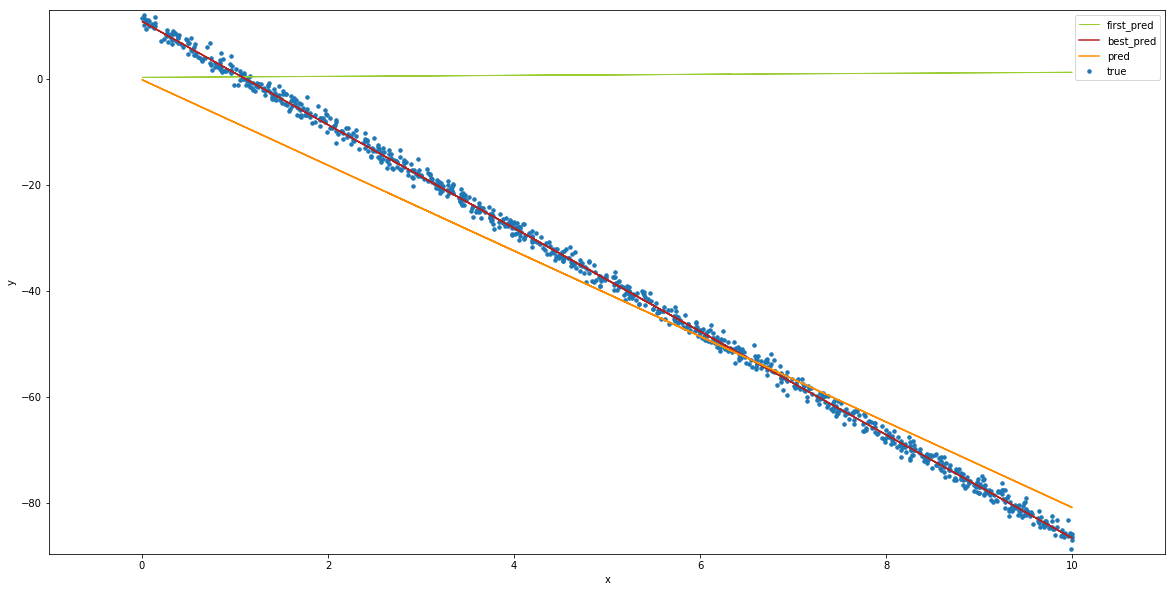

In [26]:
show_regressor_linear_sgd(
    x,
    y,
    rgs.coef_list,
    rgs.best_coef_,
    rgs.intercept_list,
    rgs.best_intercept_,
    pause_second=0.001,
    step=10,
    max_iter=20
)

#### 3.3.1 深拷贝和浅拷贝

**可变类型和不可变类型**

In [27]:
ls = ['a', 'b', 'c']
ls[0] = 1
ls

[1, 'b', 'c']

In [28]:
string = "abc"
string[0] = 1

TypeError: 'str' object does not support item assignment

In [29]:
tup = (1, 2, 3,)
tup[0] = 1

TypeError: 'tuple' object does not support item assignment

可变类型：list, dict, set  
不可变类型：tuple, str, number

In [30]:
a = [0]
b = []
for i in range(10):
    a[0] += 1
    b.append(a)
    print(b)

[[1]]
[[2], [2]]
[[3], [3], [3]]
[[4], [4], [4], [4]]
[[5], [5], [5], [5], [5]]
[[6], [6], [6], [6], [6], [6]]
[[7], [7], [7], [7], [7], [7], [7]]
[[8], [8], [8], [8], [8], [8], [8], [8]]
[[9], [9], [9], [9], [9], [9], [9], [9], [9]]
[[10], [10], [10], [10], [10], [10], [10], [10], [10], [10]]


In [31]:
import copy

a = [0]
b = []
for i in range(10):
    a[0] += 1
    b.append(copy.deepcopy(a))
    print(b)

[[1]]
[[1], [2]]
[[1], [2], [3]]
[[1], [2], [3], [4]]
[[1], [2], [3], [4], [5]]
[[1], [2], [3], [4], [5], [6]]
[[1], [2], [3], [4], [5], [6], [7]]
[[1], [2], [3], [4], [5], [6], [7], [8]]
[[1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]


In [32]:
import copy

a = [0]
b = []
for i in range(10):
    a[0] += 1
    b.append(a[:])
    print(b)

[[1]]
[[1], [2]]
[[1], [2], [3]]
[[1], [2], [3], [4]]
[[1], [2], [3], [4], [5]]
[[1], [2], [3], [4], [5], [6]]
[[1], [2], [3], [4], [5], [6], [7]]
[[1], [2], [3], [4], [5], [6], [7], [8]]
[[1], [2], [3], [4], [5], [6], [7], [8], [9]]
[[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]


#### 3.3.2 波士顿房价

In [33]:
X_data, y_data = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=12)

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rgs = NumpySGDRegressor(
    epochs=10000,
    print_step=1000,
    early_stopping=True,
    toc=0.001,
    patient=6,
    learning_rate=0.008,
    random_state=11384,
    regularize='l2',
    alpha=0.001
)
rgs.fit(X_train, y_train)

Epoch 1000: valid_data loss: 36.98657526514078
Actual iter epoch: 1614, best epoch: 1586, best loss: 17.056591788295442, best coef: [ -1.52813598   1.52584018   1.79505171   2.49387562  -3.80666039
  17.22614771   5.43289587   0.33234538   0.87898424  -2.0866713
  -4.64548923   4.14296111 -15.36128939], best intercept: 14.3372027976651


#### 3.3.3 绘制训练过程损失变化图

In [35]:
def show_regressor_loss(train_loss, valid_loss, x_magnification=1, y_magnification=1):
    """show regressor loss of the train process.

    Args:
        train_loss: list of train loss. train loss's type is np.ndarray float number.
        valid_loss: list of valid loss. valid loss's type is np.ndarray float number.
        x_magnification: magnification for x axis, a positive number, default = 1.
        y_magnification: magnification for y axis, a positive number, default = 1.
    """
    plt.figure(figsize=[10 * x_magnification, 5 * y_magnification])
    x = range(len(train_loss))
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.plot(x, train_loss, color="darkorange", label="train_loss")
    plt.plot(x, valid_loss, label="valid_loss")
    plt.legend()
    plt.show()

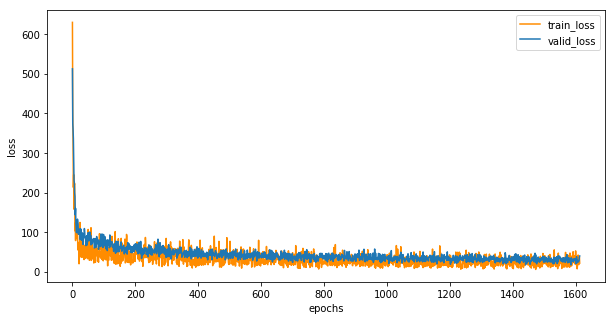

In [36]:
show_regressor_loss(rgs.train_loss[:], rgs.valid_loss[:])

In [37]:
rgs.score(X_test, y_test)

0.6209019823629415

In [38]:
rgs = NumpyLinearRegressor()
rgs.fit(X_train, y_train)
rgs.score(X_test, y_test)

0.7487680397194808

## 4. Numpy实现多项式回归

In [39]:
a = [1,1,2,3]
a.pop(0)
a

[1, 2, 3]

In [40]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=False)
poly.fit(X_train)
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x0 x8',
 'x0 x9',
 'x0 x10',
 'x0 x11',
 'x0 x12',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x1 x6',
 'x1 x7',
 'x1 x8',
 'x1 x9',
 'x1 x10',
 'x1 x11',
 'x1 x12',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x2 x6',
 'x2 x7',
 'x2 x8',
 'x2 x9',
 'x2 x10',
 'x2 x11',
 'x2 x12',
 'x3^2',
 'x3 x4',
 'x3 x5',
 'x3 x6',
 'x3 x7',
 'x3 x8',
 'x3 x9',
 'x3 x10',
 'x3 x11',
 'x3 x12',
 'x4^2',
 'x4 x5',
 'x4 x6',
 'x4 x7',
 'x4 x8',
 'x4 x9',
 'x4 x10',
 'x4 x11',
 'x4 x12',
 'x5^2',
 'x5 x6',
 'x5 x7',
 'x5 x8',
 'x5 x9',
 'x5 x10',
 'x5 x11',
 'x5 x12',
 'x6^2',
 'x6 x7',
 'x6 x8',
 'x6 x9',
 'x6 x10',
 'x6 x11',
 'x6 x12',
 'x7^2',
 'x7 x8',
 'x7 x9',
 'x7 x10',
 'x7 x11',
 'x7 x12',
 'x8^2',
 'x8 x9',
 'x8 x10',
 'x8 x11',
 'x8 x12',
 'x9^2',
 'x9 x10',
 'x9 x11',
 'x9 x12',
 'x10^2',
 'x10 x11',
 'x10 x1

### 4.1 NumpyPolynomialFeatures

In [41]:
class NumpyPolynomialFeatures:
    """Polynomial Features transformor with Numpy.
    
    Attributes:
        degree: degree of power. A positive int number and 
            must be greater than 1, default = 2.
        interaction_only: if only transform to the interaction. 
            A bool value, default = False.
        include_bias: if include bias(intercept). A bool value,
            default = true.
    """
    def __init__(self, degree=2, interaction_only=False, include_bias=True):
        """NumpyPolynomialFeatures initial method.
        
        Args:
            degree: degree of power. A positive int number and 
                must be greater than 1, default = 2.
            interaction_only: if only transform to the interaction. 
                A bool value, default = False.
            include_bias: if include bias(intercept). A bool value,
                default = true.
        """
        self.degree, self.interaction_only, self.include_bias = self._init_validation(degree, interaction_only, include_bias)
        self._feature_func_dict = {}
        self._is_fitted = False
    
    def fit(self, X_train):
        """fit method.
        
        Args:
            X_train: A np.ndarray matrix of (n_samples, n_features) shape, 
                data type must be continuous value type. 
        Returns:
            return self object.
        """
        X_train = self._X_validation(X_train)
        if self._is_fitted:
            self.__init__(self.degree, self.interaction_only, self.include_bias)
        for i in range(X_train.shape[1]):
            self._feature_func_dict[(i, )] = lambda X: X[:, i].reshape([-1, 1])
        last_end = 0
        for loop in range(self.degree - 1):
            for j in range(last_end, len(self._feature_func_dict)):
                for k in range(0, X_train.shape[1]):
                    key_list = [*self._feature_func_dict]
                    if not (key_list[k][0] in key_list[j] and self.interaction_only):
                        new_key = self._sorted_insert_tuple(key_list[k][0], key_list[j])
                        if new_key not in self._feature_func_dict:
                            self._feature_func_dict[new_key] = lambda X: reduce(lambda x, y: (X_train[:, x] if isinstance(x, int) else x) * X_train[:, y], new_key).reshape([-1, 1]) 
                last_end += 1
        if self.include_bias:
            self._feature_func_dict["bias"] = lambda X: np.ones([X.shape[0], 1])
        self._is_fitted = True
        return self
        
    def transform(self, X, _miss_valid=False):
        """transform the data.
        
        Args:
            X: A np.ndarray matrix of (n_samples, n_features) shape, 
                data type must be continuous value type. 
        Returns:
            return a new X, a np.ndarray matrix of (n_samples, 
                new_n_features) shape.
        """
        if not _miss_valid:
            X = self._X_validation(X)
        new_X = np.array([[] for _ in range(X.shape[0])])
        for key in self._feature_func_dict:
            new_X = np.c_[new_X, self._feature_func_dict[key](X)]
        return new_X         
    
    def fit_transform(self, X_train):
        """fit transformer and transform data.
        
        Args:
            X_train: A np.ndarray matrix of (n_samples, n_features) shape, 
                data type must be continuous value type. 
        Returns:
            return a new X, a np.ndarray matrix of (n_samples, 
                new_n_features) shape.
        """
        self.fit(X_train)
        return self.transform(X_train, _miss_valid=True)
        
    def get_feature_names(self):
        """get the new features' name
        
        Returns:
            return a list with the tuples of old feature's num. 
                e.g: [(0,), (0, 0)], [(0,), (1,), (0, 0), (0, 1), (1, 1)].
        """
        return [*self._feature_func_dict]
    
    def _init_validation(self, degree, interaction_only, include_bias):
        assert isinstance(degree, int) and degree >= 1
        assert isinstance(interaction_only, bool)
        assert isinstance(include_bias, bool)
        return degree, interaction_only, include_bias
    
    def _X_validation(self, X):
        assert isinstance(X, Iterable)
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        assert X.ndim == 2
        return X
    
    def _sorted_insert_tuple(self, item, tuple_):
        idx = len(tuple_)
        for i in range(len(tuple_)):
            if tuple_[i] < item:
                i += 1
            else:
                idx = i
                break
        tuple_ = tuple_[:idx] + (item,) + tuple_[idx:]
        return tuple_

#### 4.1.1 reduce

In [42]:
from functools import reduce

sum_ = lambda lst: reduce(lambda x, y: x + y, lst)
sum_([1,2,3,4])

10

#### 4.2 从公式加载数据

In [43]:
def load_data_from_func(func=lambda X_data: 2.1084 * np.square(X_data) - 0.1932 * X_data + 10.813,
                        x_min=0, x_max=10, n_samples=500, loc=0, scale=1, random_state=None):
    """load point data from a function

    Args:
        func: Function for creating data.A Function object, default = lambda X_data:
            2.1084 *  np.square(X_data) - 0.1932 * X_data + 10.813.
        x_min: min value of x. A number, x_min must be less ther x_max, default = 0.
        x_max: max value of x. A number, x_max must be greater ther x_min, default = 0.
        n_samples: sample count. A int number, default = 500.
        loc: loc of noise's destribution. A float number, default = 0.
        scale: scale of noise's destribution. A float number, default = 1.
        random_state: random seed. A positive int number, default = None.
    
    Returns:
        A tuple of x and y. x's shape is (n_samples, 1), y's shape is (n_samples, ).
    """
    if random_state is not None and isinstance(random_state, int):
        np.random.seed(random_state)
    x = np.random.uniform(x_min, x_max, n_samples)
    y = func(x)
    noise = np.random.normal(loc=loc, scale=scale, size=n_samples)
    y += noise
    return x.reshape([-1, 1]), y
x, y = load_data_from_func(x_max=100, scale=1)
x.shape, y.shape

((500, 1), (500,))

In [44]:
def show_linear_point(X_data, y_data, s=12):
    """Plot linear point

    Args:
         X_data: X_data with (sample_count, 1) shape.
         y_data: y_data with (sample_count, 1) shape.
    """
    plt.figure(figsize=[10, 5])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(X_data, y_data, s=s)
    plt.show()

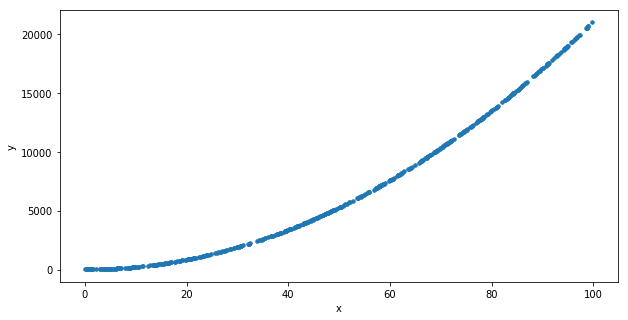

In [45]:
show_linear_point(x, y)

In [46]:
np_poly = NumpyPolynomialFeatures(include_bias=False)
x_poly_numpy = np_poly.fit_transform(x)

In [47]:
np_poly.get_feature_names()

[(0,), (0, 0)]

In [48]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(include_bias=False)
x_poly = poly.fit_transform(x)

In [49]:
poly.get_feature_names()

['x0', 'x0^2']

In [50]:
x_poly_numpy[:20]

array([[4.49601864e+01, 2.02141837e+03],
       [6.22596794e+01, 3.87626768e+03],
       [3.04498278e+01, 9.27192015e+02],
       [3.54289356e+01, 1.25520948e+03],
       [6.56513314e+01, 4.31009732e+03],
       [1.41186557e+01, 1.99336439e+02],
       [5.03662236e+01, 2.53675648e+03],
       [3.43300964e+01, 1.17855552e+03],
       [7.52583689e+01, 5.66382210e+03],
       [1.69168757e+01, 2.86180683e+02],
       [9.28814316e+00, 8.62696033e+01],
       [9.49787993e+01, 9.02097232e+03],
       [9.31843900e+01, 8.68333054e+03],
       [7.58852847e+01, 5.75857643e+03],
       [2.59316245e+01, 6.72449151e+02],
       [3.77060456e+01, 1.42174587e+03],
       [6.28644172e+00, 3.95193496e+01],
       [6.04959832e+00, 3.65976399e+01],
       [1.22024755e+00, 1.48900409e+00],
       [4.40397703e+01, 1.93950137e+03]])

In [51]:
x_poly[:20]

array([[4.49601864e+01, 2.02141837e+03],
       [6.22596794e+01, 3.87626768e+03],
       [3.04498278e+01, 9.27192015e+02],
       [3.54289356e+01, 1.25520948e+03],
       [6.56513314e+01, 4.31009732e+03],
       [1.41186557e+01, 1.99336439e+02],
       [5.03662236e+01, 2.53675648e+03],
       [3.43300964e+01, 1.17855552e+03],
       [7.52583689e+01, 5.66382210e+03],
       [1.69168757e+01, 2.86180683e+02],
       [9.28814316e+00, 8.62696033e+01],
       [9.49787993e+01, 9.02097232e+03],
       [9.31843900e+01, 8.68333054e+03],
       [7.58852847e+01, 5.75857643e+03],
       [2.59316245e+01, 6.72449151e+02],
       [3.77060456e+01, 1.42174587e+03],
       [6.28644172e+00, 3.95193496e+01],
       [6.04959832e+00, 3.65976399e+01],
       [1.22024755e+00, 1.48900409e+00],
       [4.40397703e+01, 1.93950137e+03]])

In [52]:
x_poly == x_poly_numpy

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ Tr

In [53]:
from sklearn.linear_model import LinearRegression, Ridge
rgs = LinearRegression().fit(x_poly_numpy, y)
rgs.coef_, rgs.intercept_

(array([-0.18914699,  2.10838344]), 10.778435171768251)

In [54]:
rgs = NumpyLinearRegressor().fit(x_poly_numpy, y)
rgs.coef_, rgs.intercept_

(array([-0.18914699,  2.10838344]), 10.778435171720943)

In [55]:
rgs = NumpyLinearRegressor().fit(x_poly, y)
rgs.coef_, rgs.intercept_

(array([-0.18914699,  2.10838344]), 10.778435171720943)

## 5. Numpy实现LWLR

$\begin{align}
w(i, i)=\exp \left(\frac{||x^{(i)}-x||_{2} ^ 2}{-2 k^{2}}\right)
\end{align}$

$
\begin{align}
J(a, b)= \sum_{i=1}^{N} w_{i}\left(y_{i}-a x_{i}-b\right)^{2}
\end{align}
$  

$\begin{align}
\hat{a}^*=\left( X ^{ T } W X \right)^{-1} X ^{ T } W y
\end{align}$

### 5.1 LWLR

In [56]:
class NumpyLWLR(NumpyBaseLinearRegressor):
    """Locally Weighted Linear Regression model with Numpy, explicitly inherits 
        from NumpyBaseLinearRegressor already.
    
    Attributes:
        _X_train: feature data for training. A np.ndarray matrix of (n_samples, n_features)
            shape, data type must be continuous value type. 
        _y_train: label data for training. A np.ndarray array of (n_samples, ) shape, 
            data type must be continuous value.
        k: the k of gaussian kernal. A float number not 0, default = 1.0
    """
    def __init__(self, k=1.0, fit_intercept=True, random_state=None):
        """NumpyLWLR initial method
        
        Args:
            k: the k of gaussian kernal. A float number, default = 1.0
            fit_intercept: if fit intercept. A bool value, default = True.
            random_state: random seed. A int number if random_state is 
                not None else None, default = None.
        """
        super().__init__(fit_intercept=fit_intercept, random_state=random_state)
        self.k = self._init_validation_self(k)
    
    def fit(self, X_train, y_train):
        """method for training model. 
        
        Args:
            X_train: A np.ndarray matrix of (n_samples, n_features) shape, data type 
                must be continuous value type. 
            y_train: A np.ndarray array of (n_samples, ) shape.
            
        Returns:
            self object.
        """
        self._X_train, self._y_train = self._fit_validation(X_train, y_train)
        return self
    
    def predict(self, X_test, _miss_valid=False):
        """predict test data.
        
        Args:
            X_test: A np.ndarray matrix of (n_samples, n_features) shape, 
                or a np.ndarray array of (n_features, ) shape.
        
        Returns:
            result of predict. A np.ndarray array of (n_samples, ) shape,
                or a float number.
        """
        if not _miss_valid:
            X_test = self._predict_validation(X_test)
        if self.intercept_ is not None:
            self._X_train = np.c_[self._X_train, np.ones(shape=(self._X_train.shape[0], 1), dtype=np.float32)]
            X_test = np.c_[X_test, np.ones((X_test.shape[0], 1))]
        if X_test.ndim == 1:
            result = self._predict_one(X_test)
            if self.intercept_ is not None:
                self._X_train = np.delete(self._X_train, -1, axis=1)
            return result
        else:
            results = []
            for x_test in X_test:
                results.append(self._predict_one(x_test))
            if self.intercept_ is not None:
                self._X_train = np.delete(self._X_train, -1, axis=1)
            return np.array(results)
    
    def _predict_one(self, x_test):
        w = self._calculate_weight(x_test)
        xtx = self._X_train.T @ (w @ self._X_train)
        try:
            xtx_inv = np.linalg.inv(xtx)
        except np.linalg.LinAlgError as ex:
            raise ex
        self.coef_ = xtx_inv @ self._X_train.T @ w @ self._y_train
        return x_test @ self.coef_
    
    def _init_validation_self(self, k):
        assert isinstance(k, (int, float))
        return k
    
    def _calculate_weight(self, x_test):
        w = np.eye(self._X_train.shape[0])
        for i in range(self._X_train.shape[0]):
            diff = self._X_train[i] - x_test
            w[i, i] = np.exp(diff @ diff.T / (-2 * self.k ** 2))
        return w

In [57]:
class A:
    def __init__(self, name):
        self.call_name(name)
    
    def call_name(self, name):
        print(name)
        
class B(A):
    def __init__(self, name, age):
        self.call_name(age)
        super().__init__(name)
        
    def call_name(self, age):
        print(age + 1)

B('Alice', 14)

15


TypeError: can only concatenate str (not "int") to str

In [58]:
x, y = load_data_from_func(func=lambda x: 10 * np.sin(x) - 0.134 * x**2 + 4.0872 * x, scale=1, random_state=1091)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1832)

In [59]:
rgs = NumpyLWLR(k=0.1)
rgs.fit(X_train, y_train)
rgs.score(X_test, y_test)

0.9897665708601325

### 5.2 绘制回归曲线

In [60]:
def show_regression_line(X_data, y_data, y_pred):
    """show regression line no only linear regression.

    Args:
        X_data: A np.ndarray matrix of (point_count, 1) shape,
            data type must be continuous value type.
        y_data: A np.ndarray array of (point_count, ) shape.
        y_pred: A np.ndarray array of (point_count, ) shape.
    """
    plt.figure(figsize=[10, 5])
    if X_data.ndim == 2:
        X_data = X_data.reshape(-1)
    plt.scatter(X_data, y_data)
    idx = np.argsort(X_data)
    X_data = X_data[idx]
    y_pred = y_pred[idx]
    plt.plot(X_data, y_pred, color="darkorange")
    plt.show()

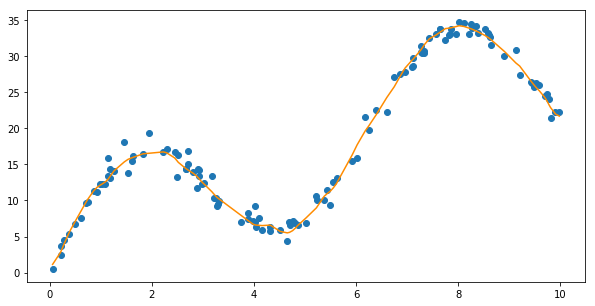

In [61]:
y_pred = rgs.predict(X_test)
show_regression_line(X_test, y_test, y_pred)

## 总结

1. API  
    > * 1.1 np.linalg.inv(a)  
        >> * 求矩阵的逆矩阵  
        >> * 如果矩阵是奇异矩阵不可逆  
    > * 1.2 np.random.seed(seed)
        >> * 设置随机数种子，保证多次执行代码，得到的随机结果一致
    > * 1.3 np.random.randn(d0, d1, ... , dn)
        >> * 用标准正态分布随机生成数据
    > * 1.4 np.random.uniform(low=0.0, high=1.0, size=None)
        >> * 均匀分布生成数据
    > * 1.5 np.random.choice(a, size=None)
        >> * 从a中随机选择size大小的数据
    > * 1.6 np.c_[]
        >> * 按列合并多个矩阵
        >> * 是**方括号**，不是**圆括号**  
    > * 1.7 np.delete(arr, obj, axis=None)
        >> * 按axis删除数据
    > * 1.8 np.identity(n)
        >> * 生成单位矩阵(方阵)
    > * 1.9 np.eye(N, M=None, k=0)  
        >> * 生成对角矩阵  
        >> * 不一定是方阵，默认M = N为方阵  
        >> * k是对角线向右的偏移量

2. 抽象类  
    > * 2.1 NumpyBaseEstimator  
        >> * 抽象出各种方法的参数验证方法，_fit_validation(X, y), _predict_validation(X_test), _score_validation(X_test, y_test)  
    > * 2.2 NumpyRegressorMixin
        >> * Regressor实现的score方法都一样，调用predict方法得到预测值，然后计算R^2指标  
        >> * 可将score方法抽象成Regressor的Mixin类，每个Regressor继承该类即可继承score方法。  
        >> * Mixin设计模式：只将方法抽象出来，Mixin类不可被实例化，且没有属性。  
    > * 2.3 NumpyBaseLinearRegressor  
        >> * LinearRegressor 和 Ridge只是计算coef_闭式解的公式不同  
        >> * 抽象出NumpyBaseLinearRegressor类，LinearRegressor和Ridge只需单独修改计算coef闭式解的方法即可  
    > * 2.4 NumpySGDBaseEstimator  
        >> * SGD无论是分类还是回归，大部分代码都类似，抽象出NumpySGDBaseEstimator，减少写回归SGD时的代码量  

3. SGD流程
    >```python
    """
    for epoch in arange(epoch):
        for batch in batch_ganerator(X_train, y_train):
            1. 计算预测值y_pred_batch
            2. 计算loss
            3. 计算导数
            4. 计算累计平均损失，并输出
            5. 更新参数
        for batch in batch_ganerator(X_valid, y_valid, shuffle=False):
            1. 计算valid累计平均损失
        1. 输出valid的累计平均损失  
        2. 保存最优参数  
        3. 判断early stopping  
    """
    > ```
    
4. Python指南
    > * 4.1 深拷贝
        >> import copy
        >> copy.deepcopy(x)
    > * 4.2 reduce
        >> from functools import reduce
        >> sum_ = lambda lst: reduce(lambda x, y: x + y, lst)
    > * 4.3 继承
        >> * 子类重写父类的某个方法，若父类的另一个方法也调用了他，调用的也会变成重写的方法。  
        >> * 多继承中，先继承的类 方法优先。  

## 作业

1. 惯例，敲两遍以上  
2. 熟悉各个API的输入输出  
3. 查找Lasso的numpy实现  
4. numpy实现StandardScaler  

## 相关链接   

<a href="./02.1.LinearRegression.ipynb" style=""> 2.1 线性回归、岭回归、Lasso、SGD、局部加权线性回归原理</a>    
<a href="./02.2.LinearRegression-sklearn.ipynb" style=""> 2.2 sklearn中使用线性回归、岭回归、Lasso、SGD、多项式回归  </a>  
   
<a href="./02.4.LinearRegression-tf2.ipynb"> 2.4 TensorFlow2实现线性回归、岭回归、SGD回归、LWLR </a>  
<a href="./02.5.LinearRegression-torch1.ipynb"> 2.5 PyTorch1实现线性回归、岭回归、SGD回归 、LWLR</a>  

## 项目源码  

https://github.com/LossJ     
进入后点击Statistic-Machine-Learning